# Logistic Regression練習

ref http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex4/ex4.html

## 牛頓法的迭代後的結果
- w = theano.shared(floatX([0.1589, 0.1483]))
- b = theano.shared(-16.38)
- cost 大概0.41X多

## mini-batch跑gradient，cost差不多都在0.6左右

## 做了feature scaling後，cost就很平滑的降下來了

In [64]:
%pylab inline
import theano
import theano.tensor as T
import itertools as it

Populating the interactive namespace from numpy and matplotlib


In [65]:
def floatX(X):
    return np.asarray(X, dtype=theano.config.floatX)

## make batches

In [66]:
### make batches
def mk_batches(x_data, y_data, batch_size, shuffle=False):
    x_batch = list()
    y_batch = list()
    
    x_data_size = x_data.shape[0]
    y_data_size = y_data.shape[0]
    assert x_data_size == y_data_size , 'the x, y dimension is error'
    
    if shuffle:
        indices = np.arange(x_data_size)
        np.random.shuffle(indices)
    
    #range(start, stop, step)
    for start_idx in range(0, x_data_size, batch_size):
        if shuffle:
            idx = indices[start_idx : start_idx + batch_size]            
        else:
            idx = slice(start_idx, start_idx + batch_size)
            
        x_batch.append(x_data[idx])
        y_batch.append(y_data[idx])
    
    return x_batch, y_batch

## feature scaling (可以讓gradient走的順一點)
http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2016/Lecture/Gradient%20Descent%20(v2).pdf#page=21

In [67]:
def feature_scaling(x_data):
    return (x_data - np.mean(x_data)) / np.std(x_data)

## 參數調整

In [68]:
BATCH_SIZE = 10
LEARNING_RATE = 0.001
EPOCHS = 1000

## Load Data

In [69]:
batch_size = BATCH_SIZE
x_data = floatX(np.loadtxt('.\ex4x.dat'))
y_data = floatX(np.loadtxt('.\ex4y.dat'))

## 資料長這樣 (學生分數有沒有過關)
- 將x data分成兩類 (0/1)
- 0 = 被當掉
- 1 = pass

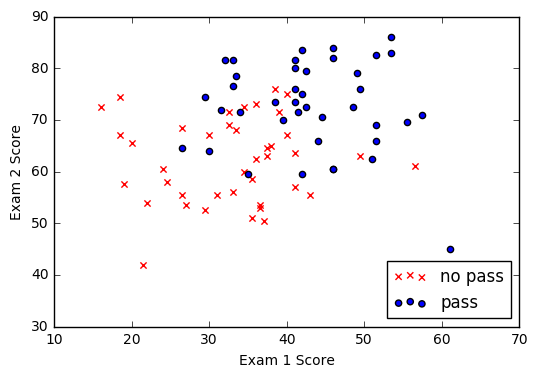

In [70]:
x_data_0 = x_data[y_data==0]
x_data_1 = x_data[y_data==1]
p1 = plt.scatter(x_data_0[:,0], x_data_0[:,1], c='r', marker='x', label='no pass')
p2 = plt.scatter(x_data_1[:,0], x_data_1[:,1], c='b', marker='o', label='pass')
plt.legend(loc=4)
plt.xlabel("Exam 1 Score")
plt.ylabel("Exam 2 Score")
plt.show()

## 初始化權重

In [71]:
### params / init weights
w = theano.shared(floatX(np.random.randn(2))) #有兩個x就要搭配兩個w
b = theano.shared(floatX(np.random.randn(1))[0])

# Model

In [72]:
x = T.matrix()
z = T.dot(w, x.T) + b
y = 1 / (1 + T.exp(-1 * z))
f = theano.function([x], y)

# Cost

In [73]:
y_hat = T.vector()
cost = -T.mean(y_hat * T.log(y) + (1 - y_hat) * T.log(1 - y))

# <span style='color:red'>很重要</span>
## 這邊稍微離題講一下vector & matrix

### 搞清楚w, x, b, y是scalar, vector還是matrix
### 搞清楚dot
### x要轉置

In [74]:
weights = np.random.randn(2)
bias = np.random.randn(1)

print 'x是matrix, 有x1, x2'
print x_data.shape
print 'w是躺平的vector, 長度2, 想成dim=1x2, 有幾個x就幾個w'
print weights.shape
print '想計算w*x, 要用dot, dot = 1x2 * 2x80 = 1 x 80'
a = np.dot(weights, np.transpose(x_data))
print a.shape
print '加上bias常數項'
print a + bias
print 'y_hat (target) 也是躺平的vector, 長度80'
print y_data.shape

x是matrix, 有x1, x2
(80L, 2L)
w是躺平的vector, 長度2, 想成dim=1x2, 有幾個x就幾個w
(2L,)
想計算w*x, 要用dot, dot = 1x2 * 2x80 = 1 x 80
(80L,)
加上bias常數項
[-71.13035858 -58.9415243  -72.70055548 -64.59845555 -57.18930972
 -66.93335382 -64.99874305 -58.5397228  -72.04347501 -73.50264449
 -58.50309216 -58.61298407 -64.16040191 -59.45132522 -66.4227959
 -57.73687678 -64.63432919 -69.89021593 -60.10878419 -58.61222707
 -49.67140749 -50.62039755 -47.15297753 -50.7665416  -55.14480704
 -43.86795369 -71.38450204 -66.56893995 -40.40091217 -49.59814621
 -60.40145079 -45.65679891 -54.88990659 -66.27627335 -57.2621925
 -60.03627992 -47.99169718 -54.63462763 -49.74466876 -59.45132522
 -48.10083209 -48.2103455  -36.97012278 -31.20367813 -47.59027417
 -51.64151339 -46.6409056  -48.06420145 -30.36344447 -48.28360677
 -41.27701946 -38.42967076 -32.77349652 -54.74376254 -48.06533696
 -54.7075104  -55.29057259 -33.50270276 -49.67065048 -43.02809854
 -55.18219468 -56.49597712 -51.31297315 -36.93349215 -44.52503416
 -45.18135762 

## gradient

In [75]:
### gradients
def gd(params, grads, lr):
    updates = []
    for p, g in it.izip(params, grads):      
        updates.append([p, p - lr*g])
    return updates
    
dw, db = T.grad(cost, [w, b])
train = theano.function(inputs=[x, y_hat],
                        outputs=[cost, w, b],
                        updates=gd([w, b], [dw, db], LEARNING_RATE))

## training

In [76]:
# training
def training(epochs, x_data, y_data):
    costs = []
    for t in range(epochs): 
        all_cost = 0       
        x_batches, y_batches = mk_batches(x_data, y_data, BATCH_SIZE, True)        
        batch_num = len(x_batches)
        for i in range(batch_num):        
            results = train(x_batches[i], y_batches[i])            
            all_cost += results[0]
        
        costs.append(all_cost/batch_num)
    
    print 'avg cost=%f' % (costs[-1])        
    print 'w1=%f, w2=%f, b=%f' % (results[1][0], results[1][1], results[2])

    return costs, results

costs, results = training(EPOCHS, x_data, y_data)

avg cost=0.801087
w1=0.077571, w2=0.026020, b=-2.132344


## cost chart (cost下不去，已經調過learning rate, batch size，跟牛頓法的0.4還有一段差異)

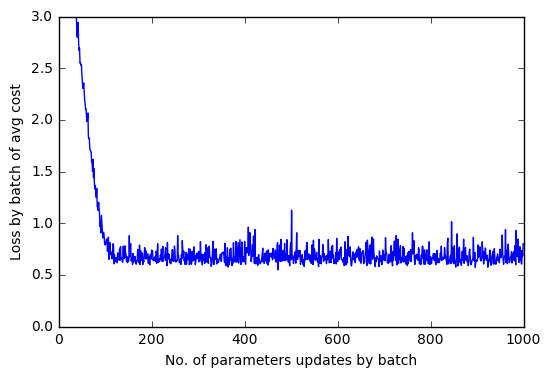

In [77]:
# cost chart
def plot_cost(costs):
    plt.plot(costs)
    plt.ylim([0, 3.0])
    plt.xlabel("No. of parameters updates by batch")
    plt.ylabel("Loss by batch of avg cost")
    plt.show()
    
plot_cost(costs)

## 那做<span style='color:red'>feature scaling</span>呢?

In [78]:
# 重新設定權重
w.set_value(floatX(np.random.randn(2)))
b.set_value(floatX(np.random.randn(1))[0])

## feature scaling有好幾種方法，這種方法做出來的mean=0, std=1

In [79]:
x_data = feature_scaling(x_data)
print 'mean=%f, std=%f' % (np.mean(x_data), np.std(x_data))

mean=-0.000000, std=1.000000


## 再training一次(結果有好一點點)

avg cost=0.473694
w1=1.158883, w2=1.134401, b=0.040164


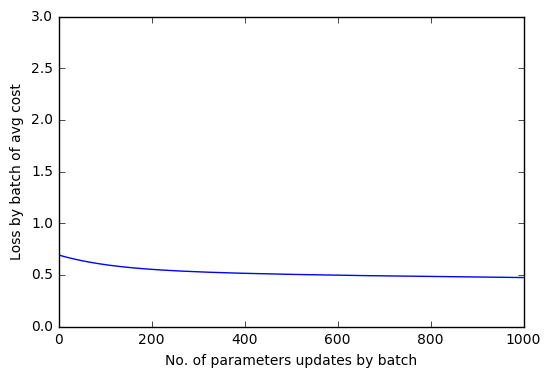

In [80]:
costs, results = training(EPOCHS, x_data, y_data)
plot_cost(costs)